In [ ]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from tqdm import tqdm

# need to install rocket fft (via pip install rocket-fft) so that fft can be performed in numba

In [2]:
hbar = 1.0
m = 1.0

## Potential & Forces

In [3]:
coeffs_free   = np.array([0.0, 0.0, 0.0, 0.0])
coeffs_harm   = np.array([0.0, 0.5, 0.0, 0.0])
coeffs_slight = np.array([0.0, 0.5, 0.1, 0.01])
coeffs_anh    = np.array([0.0, 0.0, 0.0, 0.25])

In [4]:
@njit(nopython=True, fastmath=True)
def pot_value(coeffs, x):
    pot = 0.0
    n = coeffs.size
    for i in range(n):
        pot += coeffs[i] * x ** (i + 1)
    return pot

@njit(nopython=True, fastmath=True)
def force_value(coeffs, x):
    force = 0.0
    n = coeffs.size
    for i in range(n):
        force -= coeffs[i] * (i + 1) * x ** i
    return force

@njit(nopython=True, fastmath=True)
def force_array(coeffs, x):
    force = np.zeros_like(x)
    n = coeffs.size
    for i in range(n):
        force -= coeffs[i] * (i + 1) * x ** i
    return force

C:\Users\wu152\AppData\Roaming\Python\Python312\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Exact Quantum Solution

In [5]:
def exact(n_max, beta, coeffs, order_i=1, order_j=1, t_end=20, delta_t=0.02):

    max_order = int(max(order_i,order_j,len(coeffs)))
    dim = n_max + max_order

    # Annihilation operator
    a = np.zeros((dim, dim))
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)

    # Creation operator
    a_dag = a.T

    # Position operator and its powers
    x = np.sqrt(hbar/(2*m)) * (a + a_dag)

    # List of matrices [x, x^2, x^3, ..., x^m]
    x_powers = [x]
    for i in range(0,max_order-1):
        x_powers.append(x_powers[i] @ x)

    # Potential energy matrix
    V = np.zeros((dim,dim))
    for i in range(0,len(coeffs)):
        V += coeffs[i] * x_powers[i]
    
    # Kinetic energy matrix
    P = np.sqrt(m * hbar / 2) * (a_dag - a)
    T = -(P @ P) / (2 * m)

    # Hamiltonian
    H = T + V
    H = H[:n_max,:n_max]

    E, psi = eigh(H)

    # Partition function
    Boltzmann = np.exp(-beta * E)
    Z = np.sum(Boltzmann)

    # Operator A = x^i, B = x^j
    A = x_powers[order_i-1][:n_max,:n_max]
    A_mel = psi.T @ A @ psi

    B = x_powers[order_j-1][:n_max,:n_max]
    B_mel = psi.T @ B @ psi

    # Build outer products for broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            Boltzmann[:, None],
            (Boltzmann[None, :] - Boltzmann[:, None]) / (beta * dE)
        )

    # A_nm * B_mn
    AB_prod = A_mel * B_mel.T

    # Time evolution
    times = np.arange(0, t_end, delta_t)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, AB_prod).real / Z

    return times, C_t


## Classical Solution

In [6]:
@njit(nopython=True, fastmath=True)
def verlet_trajectory(x0, v0, coeffs, delta_t, Nsteps):
    x = np.empty(Nsteps)
    v = np.empty(Nsteps)
    x[0] = x0
    v[0] = v0
    f = force_value(coeffs, x0)
    dt = delta_t
    half_dt2_over_m = 0.5 * dt * dt / m
    half_dt_over_m = 0.5 * dt / m
    for i in range(Nsteps - 1):
        x_new = x[i] + dt * v[i] + half_dt2_over_m * f
        f_new = force_value(coeffs, x_new)
        v_new = v[i] + half_dt_over_m * (f + f_new)
        x[i + 1] = x_new
        v[i + 1] = v_new
        f = f_new
    return x, v

In [7]:
@njit(nopython=True, fastmath=True)
def classical(beta, coeffs, N_samp, i_pow=1, j_pow=1, t_end=20, delta_t=0.02, N_preeq = 2000):
    t_values = np.arange(0.0, t_end, delta_t)
    N = t_values.size
    C = np.zeros(N)

    sigma_v = 1.0 / np.sqrt(beta * m)

    x0 = 1
    for s in range(N_preeq):
        v0 = np.random.normal(0.0, sigma_v)
        x, v = verlet_trajectory(x0, v0, coeffs, delta_t, N)
        x0 = x[-1]
    for s in range(N_samp):
        v0 = np.random.normal(0.0, sigma_v)
        x, v = verlet_trajectory(x0, v0, coeffs, delta_t, N)
        x0pow = x0 ** i_pow
        for t in range(N):
            C[t] += x0pow * (x[t] ** j_pow)
        x0 = x[-1]

    C /= N_samp
    return t_values, C

## Ring Polymer

In [8]:
@njit(nopython=True, fastmath=True)
def normal_mode_frequencies(k_eff, n):
    w = np.empty(n, dtype=np.float64)
    for k in range(n):
        w[k] = np.sqrt((2.0 - 2.0 * np.cos(2.0 * np.pi * k / n)) * k_eff / m)
    return w

@njit(nopython=True, fastmath=True)
def mode_propagation(x, v, omega, delta_t):
    #Transform to normal coordinates
    Xk = np.fft.fft(x)
    Vk = np.fft.fft(v)

    Xk_next = np.empty_like(Xk)
    Vk_next = np.empty_like(Vk)

    #Evolve the omega=0 mode
    Xk_next[0] = Xk[0] + Vk[0] * delta_t
    Vk_next[0] = Vk[0]

    # Evolve the omgea>0 mode
    omega_pos = omega[1:]
    coswt = np.cos(omega_pos*delta_t)
    sinwt = np.sin(omega_pos*delta_t)
    Xk_pos = Xk[1:]
    Vk_pos = Vk[1:]
    Xk_next[1:] = Xk_pos * coswt + Vk_pos * (sinwt / omega_pos)
    Vk_next[1:] = Vk_pos * coswt - Xk_pos * (omega_pos * sinwt)
    
    # Transform back to real coordinates
    x_next = np.fft.ifft(Xk_next, axis=0).real
    v_next = np.fft.ifft(Vk_next, axis=0).real
    return x_next, v_next

In [9]:
@njit(nopython=True, fastmath=True)
def polymer_verlet_core(x_init, v_init, k_eff, coeffs, t_end, delta_t, n):
    N = int(np.floor(t_end / delta_t + 1e-12))
    # time grid: to match your np.arange(0,t_end,dt) we record N points
    x_traj = np.zeros((N, n), dtype=np.float64)
    v_traj = np.zeros((N, n), dtype=np.float64)
    x_traj[0] = x_init
    v_traj[0] = v_init

    omega = normal_mode_frequencies(k_eff, n)  # same formula


    x = x_init.copy()
    v = v_init.copy()
    f = np.empty(n)

    for b in range(n):
        f[b] = force_value(coeffs, x[b])

    for i in range(N - 1):
        # half kick
        v_half = v + 0.5 * delta_t * f / m

        x_new, v_mode = mode_propagation(x, v_half, omega, delta_t)

        # external force at x_new
        for b in range(n):
            f[b] = force_value(coeffs, x_new[b])

        # second half kick
        v_new = v_mode + 0.5 * delta_t * f / m

        # store
        x_traj[i + 1] = x_new
        v_traj[i + 1] = v_new

        # advance
        x = x_new
        v = v_new

    return x_traj, v_traj

In [10]:
def polymer(beta, coeffs, n, N_samp, i_pow=1, j_pow=1, t_end=20, delta_t=0.02, N_preeq = 2000):
    beta_n = beta / n
    C_time = np.arange(0.0, t_end, delta_t)
    N = C_time.size
    C_func = np.zeros(N)

    x_init = np.random.normal(0.0, 1, n)
    k_eff=m/(beta_n*beta_n*hbar*hbar)

    for i in tqdm(range(N_preeq), desc="Pre-equilibration"):
        # resample velocities from Maxwell-Boltzmann at beta_n
        v_init = np.random.normal(0.0, 1.0/np.sqrt(beta_n*m), size=n)
        x_samp, _ = polymer_verlet_core(x_init, v_init, k_eff, coeffs=coeffs, t_end=t_end, delta_t=delta_t, n=n)
        x_init = x_samp[-1]  # carry last coordinates

    for i in tqdm(range(N_samp), desc='Polymer Sampling'):
        # resample velocities from Maxwell-Boltzmann at beta_n
        v_init = np.random.normal(0.0, 1.0/np.sqrt(beta_n*m), size=n)
        x_samp, _ = polymer_verlet_core(x_init, v_init, k_eff, coeffs=coeffs, t_end=t_end, delta_t=delta_t, n=n)
        x_init_avg = np.mean(x_init ** i_pow)
        x_samp_avg = np.mean(x_samp ** j_pow, axis=1)  # time axis first
        x_corr = x_init_avg * x_samp_avg
        C_func += x_corr / N_samp
        x_init = x_samp[-1]  # carry last coordinates

    return C_time, C_func

## $C_{xx}$

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [15]:
beta = 1
n = 4*beta
exact_harm = exact(20,beta,coeffs_harm)
classical_harm = classical(beta,coeffs_harm, 100000)
polymer_harm = polymer(beta,coeffs_harm, n, 100000)

Polymer Sampling: 100%|██████████| 100000/100000 [03:29<00:00, 477.83it/s]


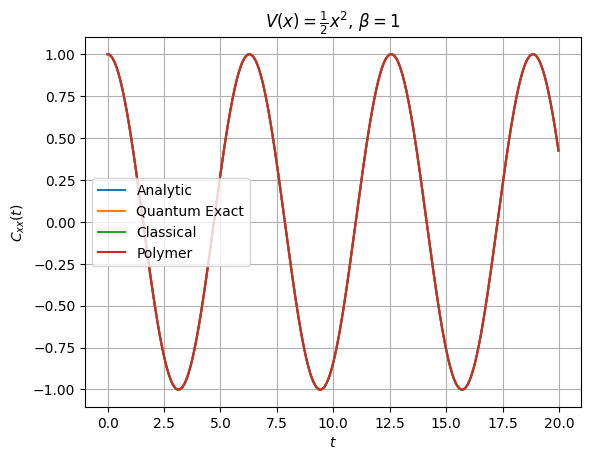

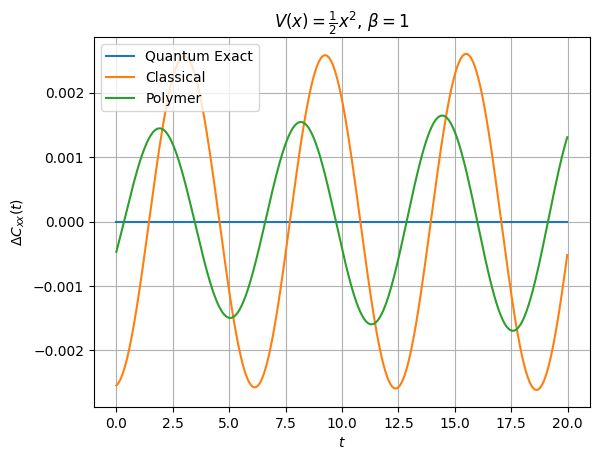

In [16]:
plt.plot(exact_harm[0], np.cos(exact_harm[0]), label='Analytic')
plt.plot(exact_harm[0], exact_harm[1], label='Quantum Exact')
plt.plot(classical_harm[0], classical_harm[1], label='Classical')
plt.plot(polymer_harm[0], polymer_harm[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()

plt.plot(exact_harm[0], np.cos(exact_harm[0])-exact_harm[1], label='Quantum Exact')
plt.plot(classical_harm[0], np.cos(classical_harm[0])-classical_harm[1], label='Classical')
plt.plot(polymer_harm[0], np.cos(polymer_harm[0])-polymer_harm[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [168]:
beta = 1
n = 4*beta
exact_sanh_highT = exact(20,beta,coeffs_slight)
class_sanh_highT = classical(beta,coeffs_slight, 100000)
polymer_sanh_highT = polymer(beta ,coeffs_slight, n, 100000)

Polymer Sampling: 100%|██████████| 100000/100000 [03:13<00:00, 517.64it/s]


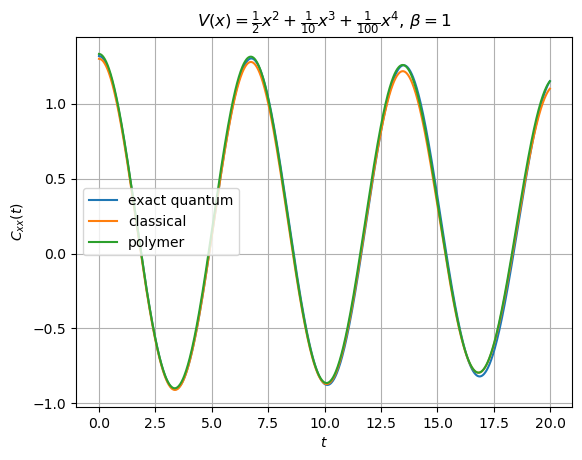

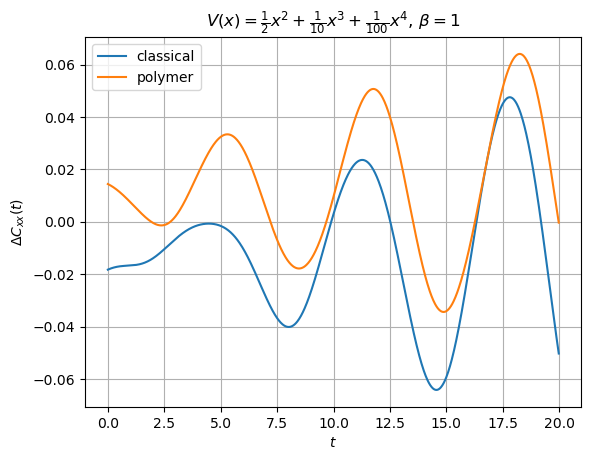

In [169]:
plt.plot(exact_sanh_highT[0], exact_sanh_highT[1], label='exact quantum')
plt.plot(class_sanh_highT[0], class_sanh_highT[1], label='classical')
plt.plot(polymer_sanh_highT[0], polymer_sanh_highT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.legend()
plt.show()

plt.plot(class_sanh_highT[0], class_sanh_highT[1]-exact_sanh_highT[1], label='classical')
plt.plot(polymer_sanh_highT[0], polymer_sanh_highT[1]-exact_sanh_highT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{xx}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.legend()
plt.show()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [170]:
beta = 8
n = 4*beta
exact_sanh_lowT = exact(20,beta,coeffs_slight)
class_sanh_lowT = classical(beta,coeffs_slight, 100000)
polymer_sanh_lowT = polymer(beta,coeffs_slight, n, 100000)

Polymer Sampling: 100%|██████████| 100000/100000 [06:39<00:00, 250.28it/s]


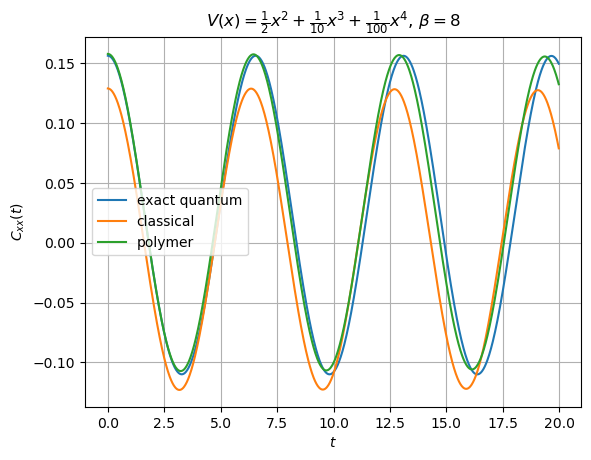

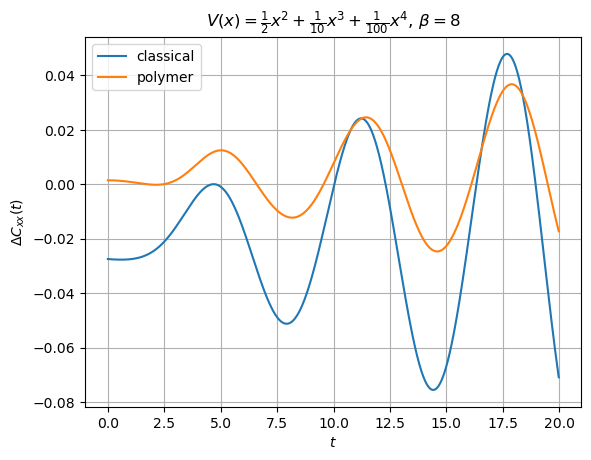

In [171]:
plt.plot(exact_sanh_lowT[0], exact_sanh_lowT[1], label='exact quantum')
plt.plot(class_sanh_lowT[0], class_sanh_lowT[1], label='classical')
plt.plot(polymer_sanh_lowT[0], polymer_sanh_lowT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.legend()
plt.show()

plt.plot(class_sanh_lowT[0], class_sanh_lowT[1]-exact_sanh_lowT[1], label='classical')
plt.plot(polymer_sanh_lowT[0], polymer_sanh_lowT[1]-exact_sanh_lowT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{xx}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.legend()
plt.show()

$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [172]:
beta = 1
n = 4*beta
exact_anh_highT = exact(20,beta,coeffs_anh)
class_anh_highT = classical(beta,coeffs_anh, 100000)
polymer_anh_highT = polymer(beta ,coeffs_anh, n, 100000)

Polymer Sampling: 100%|██████████| 100000/100000 [03:13<00:00, 516.68it/s]


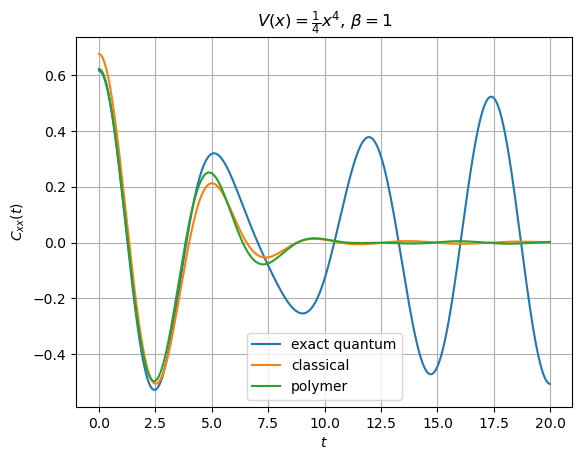

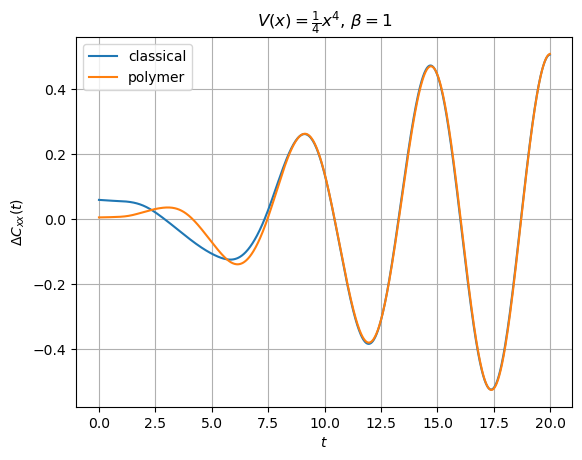

In [173]:
plt.plot(exact_anh_highT[0], exact_anh_highT[1], label='exact quantum')
plt.plot(class_anh_highT[0], class_anh_highT[1], label='classical')
plt.plot(polymer_anh_highT[0], polymer_anh_highT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


plt.plot(class_anh_highT[0], class_anh_highT[1]-exact_anh_highT[1], label='classical')
plt.plot(polymer_anh_highT[0], polymer_anh_highT[1]-exact_anh_highT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()

$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [174]:
beta = 8
n = 4*beta
exact_anh_lowT = exact(20,beta,coeffs_anh)
class_anh_lowT = classical(beta,coeffs_anh, 100000)
polymer_anh_lowT = polymer(beta ,coeffs_anh, n, 100000)

Polymer Sampling: 100%|██████████| 100000/100000 [06:39<00:00, 250.28it/s]


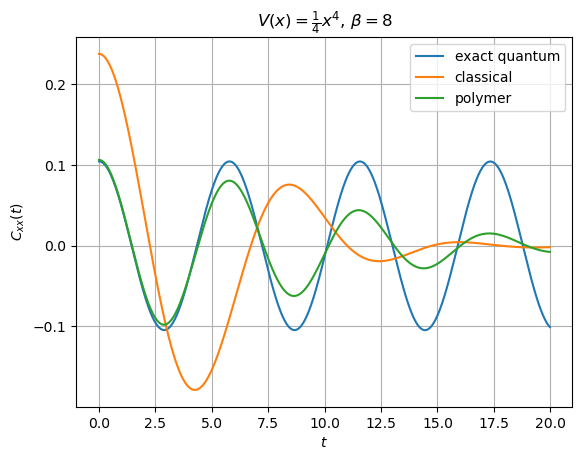

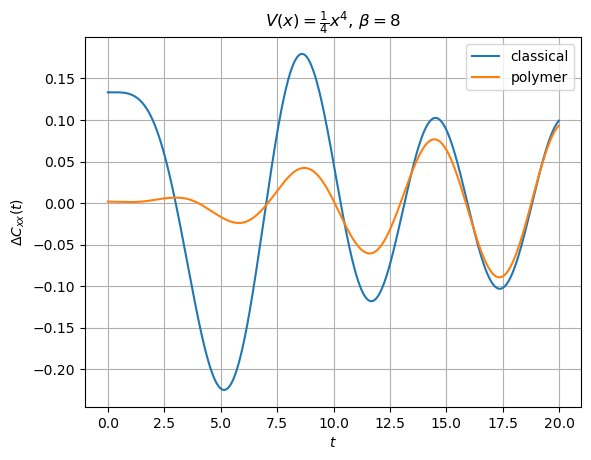

In [175]:
plt.plot(exact_anh_lowT[0], exact_anh_lowT[1], label='exact quantum')
plt.plot(class_anh_lowT[0], class_anh_lowT[1], label='classical')
plt.plot(polymer_anh_lowT[0], polymer_anh_lowT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()


plt.plot(class_anh_lowT[0], class_anh_lowT[1]-exact_anh_lowT[1], label='classical')
plt.plot(polymer_anh_lowT[0], polymer_anh_lowT[1]-exact_anh_lowT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()

## $C_{x^3 x^3}$

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [176]:
beta = 1
n = 4*beta
exact_harm_highT_cube = exact(20,beta,coeffs_harm, 3,3)
classical_harm_highT_cube = classical(beta ,coeffs_harm, 100000, 3,3)
polymer_harm_highT_cube = polymer(beta ,coeffs_harm, n, 100000, 3,3)

Polymer Sampling: 100%|██████████| 100000/100000 [03:21<00:00, 495.26it/s]


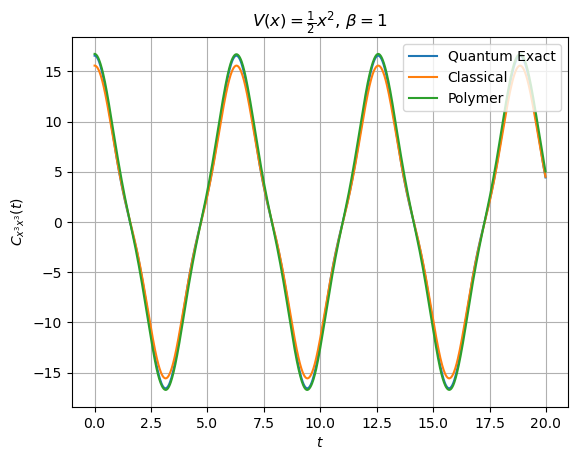

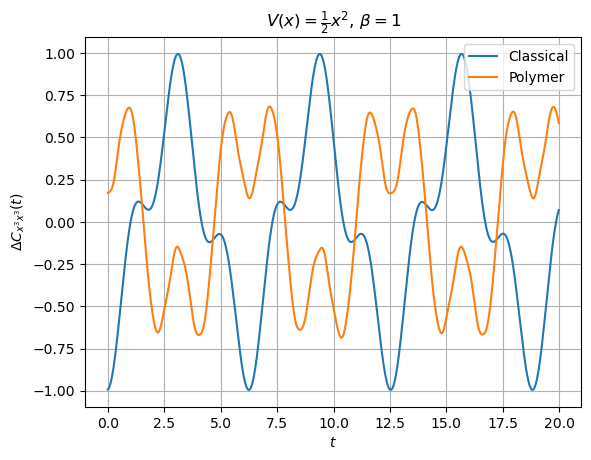

In [177]:
plt.plot(exact_harm_highT_cube[0], exact_harm_highT_cube[1], label='Quantum Exact')
plt.plot(classical_harm_highT_cube[0], classical_harm_highT_cube[1], label='Classical')
plt.plot(polymer_harm_highT_cube[0], polymer_harm_highT_cube[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


plt.plot(classical_harm_highT_cube[0], classical_harm_highT_cube[1]-exact_harm_highT_cube[1], label='Classical')
plt.plot(polymer_harm_highT_cube[0], polymer_harm_highT_cube[1]-exact_harm_highT_cube[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2$, $\beta=8$

In [178]:
beta = 8
n = 4*beta
exact_harm_lowT_cube = exact(20,beta,coeffs_harm, 3,3)
classical_harm_lowT_cube = classical(beta ,coeffs_harm, 100000, 3,3)
polymer_harm_lowT_cube = polymer(beta ,coeffs_harm, n, 100000, 3,3)

Polymer Sampling: 100%|██████████| 100000/100000 [07:48<00:00, 213.37it/s]


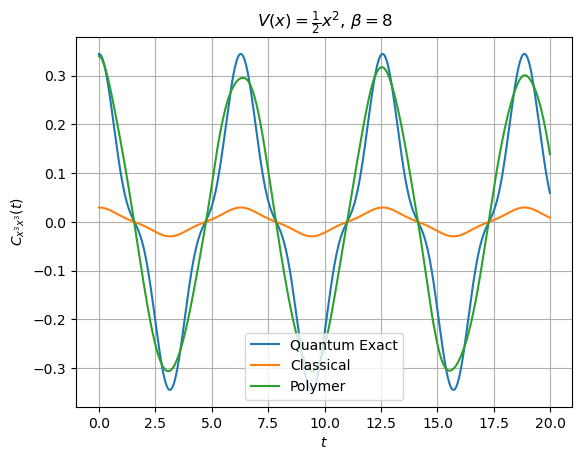

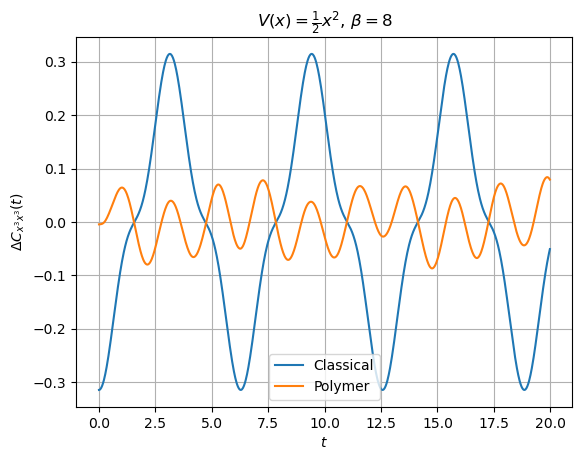

In [179]:
plt.plot(exact_harm_lowT_cube[0], exact_harm_lowT_cube[1], label='Quantum Exact')
plt.plot(classical_harm_lowT_cube[0], classical_harm_lowT_cube[1], label='Classical')
plt.plot(polymer_harm_lowT_cube[0], polymer_harm_lowT_cube[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()


plt.plot(classical_harm_lowT_cube[0], classical_harm_lowT_cube[1]-exact_harm_lowT_cube[1], label='Classical')
plt.plot(polymer_harm_lowT_cube[0], polymer_harm_lowT_cube[1]-exact_harm_lowT_cube[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [180]:
beta = 1
n = 4*beta
exact_sanh_highT_cube = exact(40,beta,coeffs_slight, 3, 3)
class_sanh_highT_cube = classical(beta,coeffs_slight, 100000, 3, 3)
polymer_sanh_highT_cube = polymer(beta ,coeffs_slight, n, 100000, 3, 3)

Polymer Sampling: 100%|██████████| 100000/100000 [03:20<00:00, 499.71it/s]


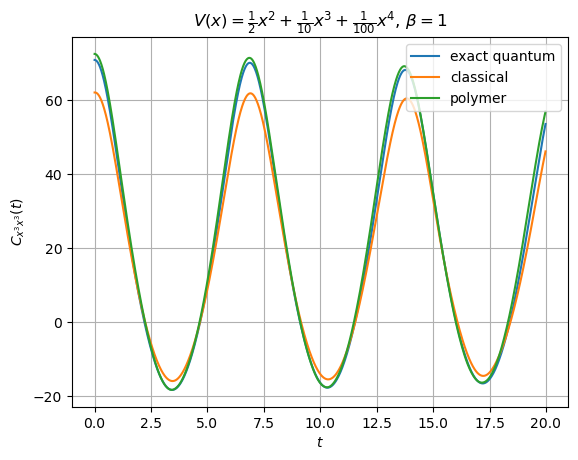

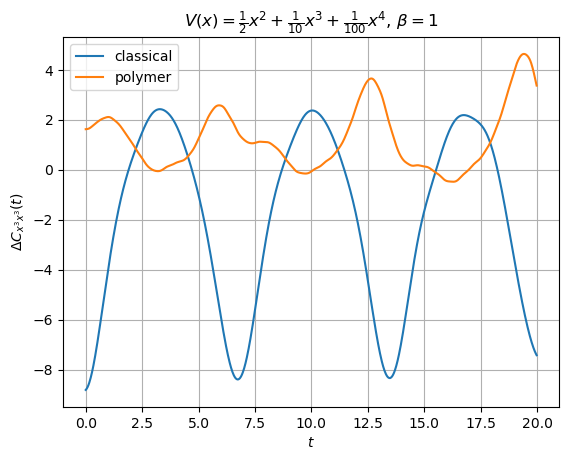

In [181]:
plt.plot(exact_sanh_highT_cube[0], exact_sanh_highT_cube[1], label='exact quantum')
plt.plot(class_sanh_highT_cube[0], class_sanh_highT_cube[1], label='classical')
plt.plot(polymer_sanh_highT_cube[0], polymer_sanh_highT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.legend()
plt.show()


plt.plot(class_sanh_highT_cube[0], class_sanh_highT_cube[1]-exact_sanh_highT_cube[1], label='classical')
plt.plot(polymer_sanh_highT_cube[0], polymer_sanh_highT_cube[1]-exact_sanh_highT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{x^3 x^3}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [182]:
beta = 8
n = 4*beta
exact_sanh_lowT_cube = exact(20,beta,coeffs_slight, 3, 3)
class_sanh_lowT_cube = classical(beta,coeffs_slight, 100000, 3, 3)
polymer_sanh_lowT_cube = polymer(beta,coeffs_slight, n, 100000, 3, 3)

Polymer Sampling: 100%|██████████| 100000/100000 [07:43<00:00, 215.74it/s]


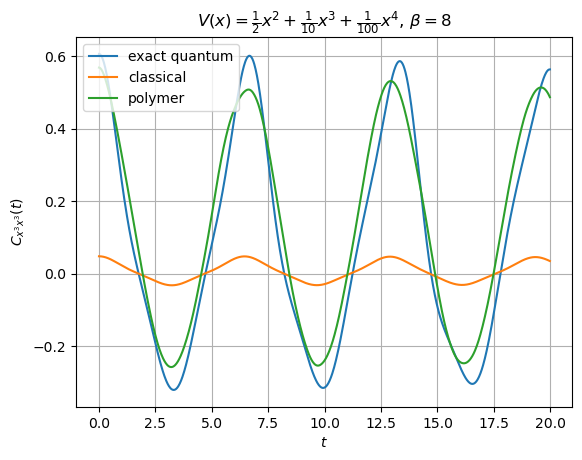

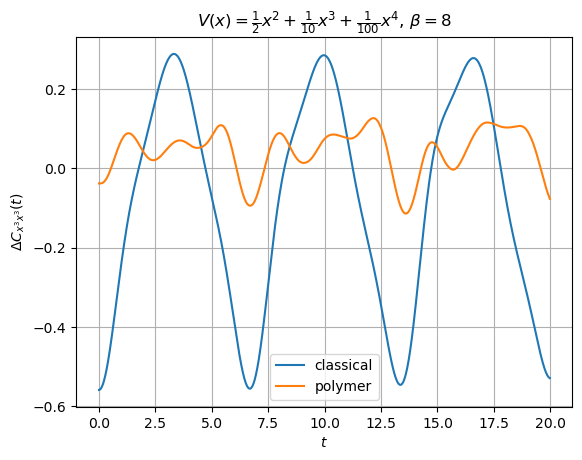

In [183]:
plt.plot(exact_sanh_lowT_cube[0], exact_sanh_lowT_cube[1], label='exact quantum')
plt.plot(class_sanh_lowT_cube[0], class_sanh_lowT_cube[1], label='classical')
plt.plot(polymer_sanh_lowT_cube[0], polymer_sanh_lowT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.legend()
plt.show()


plt.plot(class_sanh_lowT_cube[0], class_sanh_lowT_cube[1]-exact_sanh_lowT_cube[1], label='classical')
plt.plot(polymer_sanh_lowT_cube[0], polymer_sanh_lowT_cube[1]-exact_sanh_lowT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{x^3 x^3}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [184]:
beta = 1
n = 4*beta
exact_anh_highT_cube = exact(30,beta,coeffs_anh, 3, 3)
class_anh_highT_cube = classical(beta,coeffs_anh, 100000, 3, 3)
polymer_anh_highT_cube = polymer(beta ,coeffs_anh, n, 100000, 3, 3)

Polymer Sampling: 100%|██████████| 100000/100000 [03:23<00:00, 491.88it/s]


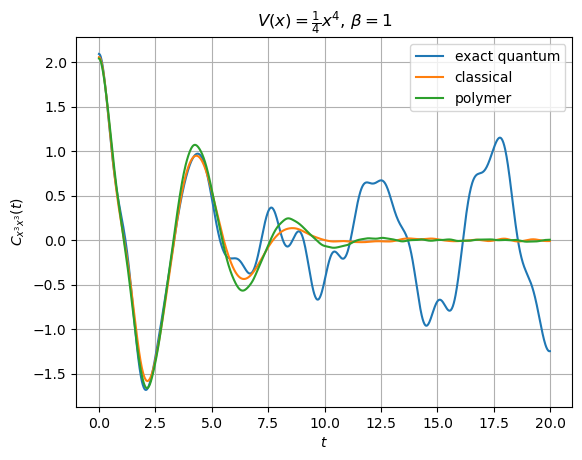

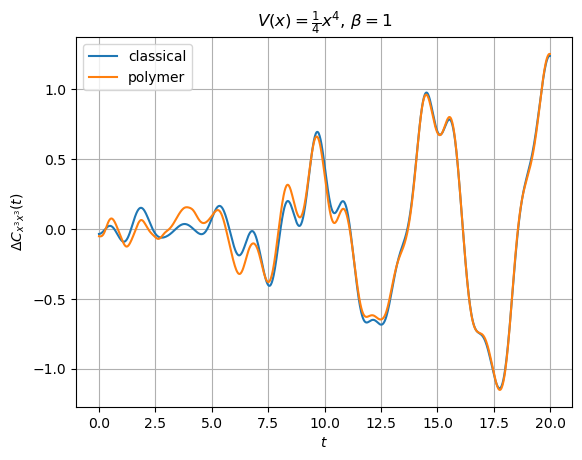

In [185]:
plt.plot(exact_anh_highT_cube[0], exact_anh_highT_cube[1], label='exact quantum')
plt.plot(class_anh_highT_cube[0], class_anh_highT_cube[1], label='classical')
plt.plot(polymer_anh_highT_cube[0], polymer_anh_highT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


plt.plot(class_anh_highT_cube[0], class_anh_highT_cube[1]-exact_anh_highT_cube[1], label='classical')
plt.plot(polymer_anh_highT_cube[0], polymer_anh_highT_cube[1]-exact_anh_highT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()

$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [186]:
beta = 8
n = 4*beta
exact_anh_lowT_cube = exact(20,beta,coeffs_anh, 3, 3)
class_anh_lowT_cube = classical(beta,coeffs_anh, 100000, 3, 3)
polymer_anh_lowT_cube = polymer(beta ,coeffs_anh, n, 100000, 3, 3)

Polymer Sampling: 100%|██████████| 100000/100000 [07:48<00:00, 213.63it/s]


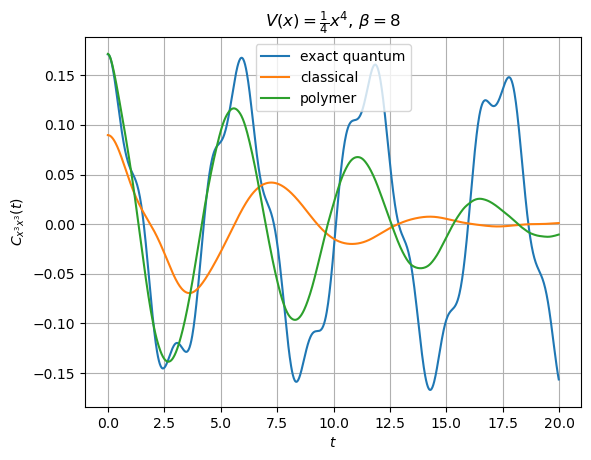

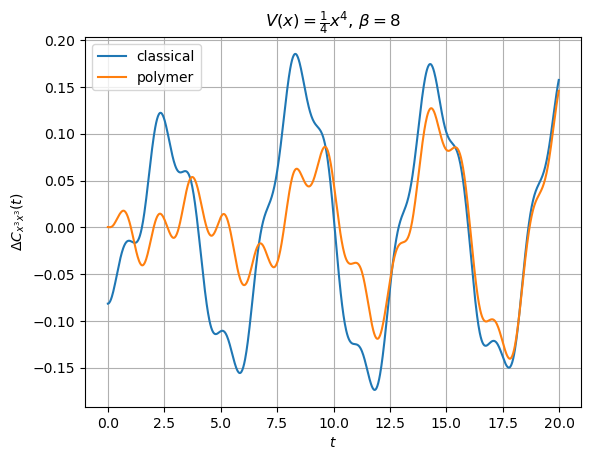

In [187]:
plt.plot(exact_anh_lowT_cube[0], exact_anh_lowT_cube[1], label='exact quantum')
plt.plot(class_anh_lowT_cube[0], class_anh_lowT_cube[1], label='classical')
plt.plot(polymer_anh_lowT_cube[0], polymer_anh_lowT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()


plt.plot(class_anh_lowT_cube[0], class_anh_lowT_cube[1]-exact_anh_lowT_cube[1], label='classical')
plt.plot(polymer_anh_lowT_cube[0], polymer_anh_lowT_cube[1]-exact_anh_lowT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Delta C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()
